In [ ]:
# Install the required packages
!pip install --upgrade langchain langchain-openai langgraph langchain-community

## Section 1: Message Summarization with SummarizationMiddleware

Key Concepts:
- Token Threshold: Summarization triggers when message count exceeds a limit
- Summary Message: LLM creates compressed version of old messages
- Recent Messages: Last N messages kept for immediate context
- Rolling Compression: Keeps conversations within token limits indefinitely

When to Use:
- Very long conversations (50+ exchanges)
- Customer support sessions where history matters
- Tutoring sessions tracking learning progress
- Research assistants remembering past discussions

When Not to Use:
- Short conversations (use full buffer)
- When exact wording matters (use external storage)
- Real-time performance critical (summarization adds latency)

How It Works:
1. Agent tracks token count as conversation grows
2. When threshold exceeded, middleware triggers
3. Old messages sent to summary model
4. Summary model creates compressed version
5. Old messages replaced with single summary message
6. Recent messages kept for immediate context
7. Conversation continues with: [Summary] + [Recent] + [New]

### 1.1 - Import Dependencies

In [ ]:
# Import the necessary components
from google.colab import userdata
from langchain.agents import create_agent  # Modern agent creation
from langchain.agents.middleware import SummarizationMiddleware  # Automatic summarization
from langchain_core.messages import HumanMessage  # Message types
from langgraph.checkpoint.memory import MemorySaver  # In-memory checkpointer
from langchain_openai import ChatOpenAI  # OpenAI model wrapper

# Retrieve the OpenAI API key from Colab's user data
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

### 1.2 - Initialize Models
Model Selection Strategy:
- Main model: Needs to be capable for good conversation quality
- Summary model: Can be a cheaper model since summarization is straightforward

In [ ]:
# Initialize the MAIN model for conversation
# This model handles the actual chat with the user
main_model = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=OPENAI_API_KEY,
    temperature=1.0  # Slightly creative for natural conversation
)

# Initialize the SUMMARY model for creating summaries
# This model creates compressed summaries of conversation history
# You can use a smaller/cheaper model here since summarization is simpler
summary_model = ChatOpenAI(
    model="gpt-4o-mini",  # Could use gpt-3.5-turbo to save costs
    api_key=OPENAI_API_KEY,
    temperature=0.3  # Lower temperature for more focused summaries
)

### 1.3 - Create Agent with Summarization Middleware

`SummarizationMiddleware` Parameters:
- `model`: ChatOpenAI instance for generating summaries
- `max_tokens_before_summary`: Token threshold that triggers summarization
  • Lower (100-500): Frequent summaries, stays under limits reliably
  • Higher (2000-4000): Less frequent, lower API costs
  • This demo: 100 (very aggressive for demonstration purposes)
- `messages_to_keep`: Number of recent messages to preserve
  • Fewer (3-5): More aggressive compression
  • More (10-20): Better immediate context
  • This demo: 3 (minimal recent context)

In [ ]:
# Create an agent that automatically summarizes long conversations
agent = create_agent(
    model=main_model,           # Main conversational model
    checkpointer=MemorySaver(), # Required for conversation persistence
    middleware=[
        SummarizationMiddleware(
            model=summary_model,              # Model to use for summarization
            max_tokens_before_summary=100,    # When to trigger (100 tokens)
            messages_to_keep=3,               # How many recent messages to keep
        ),
    ],
)

# Configuration to identify this conversation thread
# Each thread_id maintains its own conversation history
config = {"configurable": {"thread_id": "summary_demo"}}

### 1.4 - Build Conversation History
What Happens:
1. First few exchanges: All messages stored normally
2. Token count exceeded 100 tokens after a few exchanges
3. Middleware created summary of early messages
4. Replaced many old messages with 1 summary message
5. Kept last 3 messages + added new exchange
6. Result: Fewer messages but key info preserved

In [ ]:
# Series of messages that build up conversation history
# These cover different topics to test summary quality
interactions = [
    "Hi! I'm David",
    "I'm a data science professor",
    "I work with Python daily",
    "I love machine learning",
    "Specifically, I enjoy NLP work",
    "I teach computational biblical studies",
    "Tell me about neural networks",
    "What are transformers?",
    "How do they differ from RNNs?"
]

# Have the conversation
# Each invoke adds a user/human message and gets an AI response
for i, msg in enumerate(interactions, 1):
    result = agent.invoke(
        {"messages": [HumanMessage(content=msg)]},
        config=config
    )

    # Print the exchange
    print(f"Exchange {i}:")
    print(f"  User: {msg}")
    print(f"  Assistant: {result['messages'][-1].content[:100]}...")
    print()

### 1.5 - Inspect State After Summarization

In [ ]:
# Get the current state to see what's actually stored
state = agent.get_state(config)

# Calculate how much compression occurred
total_messages = len(state.values['messages'])
expected_without_summary = len(interactions) * 2  # Each exchange = 2 messages

print(f"\n{'='*70}")
print("STATE INSPECTION")
print('='*70)
print(f"\nTotal messages in state: {total_messages}")
print(f"Expected without summarization: {expected_without_summary}")
print(f"Messages saved by summarization: {expected_without_summary - total_messages}")

# View the first message in state.values
print(f"Summary message is the first in the state.values:\n{state.values["messages"][0].content}")

In [ ]:
# Show what's actually stored
print("\nMessages currently stored:")
for i, msg in enumerate(state.values['messages'], 1):
    msg_preview = msg.content[:80].replace('\n', ' ')
    print(f"{i}. [{msg.type}]: {msg_preview}...")

    # Check if this is a summary message
    # Summary messages contain compressed history
    if "summary" in msg.content.lower()[:200] or "previous conversation" in msg.content.lower()[:200]:
        print("   ⬆️  SUMMARY MESSAGE (contains compressed history)")

# Full state.values['messages']
state.values['messages']

### 1.6 - Test Memory Recall
The assistant should recall:
- Name: David (from exchange 1)
- Interests: ML, NLP, computational biblical studies (exchanges 4-6)
- Profession: Data science professor (exchange 2)

Even though early messages were summarized, the summary should
contain this key information!

In [ ]:
# Ask a question that requires information from early in the conversation
# This tests if the summary preserved key details
recall_question = "What is my name, what are my interests, and what is my profession?"

recall_convo = agent.invoke(
    {"messages": [HumanMessage(content=recall_question)]},
    config=config
)

print(f"{'='*70}")
print("MEMORY RECALL TEST")
print('='*70)
print(f"\nUser: {recall_question}\n")
print(f"Assistant: {recall_convo['messages'][-1].content}\n")

### Summary: Key Takeaways

**How Summarization Works:**

1. Agent tracks token count as conversation grows
2. When count exceeds threshold (100 tokens), summarization triggers
3. Old messages are sent to summary model
4. Summary model creates compressed version
5. Old messages replaced with summary message
6. Recent messages (last 3) kept for immediate context
7. Conversation continues with: [Summary] + [Recent] + [New]

**What Was Demonstrated:**
- Automatic summarization when threshold reached
- Key information preserved in summary
- Message count reduced significantly
- Agent still remembers early conversation details

**Configuration Tradeoffs:**

`max_tokens_before_summary`:
- Lower (100-500): More frequent summaries
  ✓ Stays under limits reliably
  ✗ More API calls, higher cost
- Higher (2000-4000): Less frequent summaries
  ✓ Fewer API calls, lower cost
  ✗ Risk of hitting context limit before summary

`messages_to_keep`:
- Fewer (3-5): More aggressive compression
  ✓ Uses fewer tokens
  ✗ Less immediate context
- More (10-20): More context preserved
  ✓ Better immediate context
  ✗ Uses more tokens

**Cost Analysis:**

Example: 100-exchange conversation (~20K tokens)

Without Summarization:
- Input tokens: 20,000 per request
- Cost: $3.00 per request (at $0.15/1M tokens)
- Eventually fails (exceeds context window)

With Summarization:
- Input tokens: 2,000 per request (after compression)
- Summary creation: 5 summaries × $0.02 = $0.10
- Cost: $0.30 per request + $0.10 summary = $0.40 total
- Savings: 87% reduction + prevents failure

**When to Use Each Strategy:**

| Conversation Length | Recommended Strategy |
|-------------------|---------------------|
| Short (< 10 exchanges) | Full buffer |
| Medium (10-50 exchanges) | Trimming |
| Long (50-200 exchanges) | Summarization |
| Very Long (200+ exchanges) | Summarization + External Storage |


## Section 2: Alternative Framework - CrewAI

**Key Concepts:**
- Role-Based Agents: Agents defined by role, goal, and backstory
- Manual Memory Management: Must pass conversation history to maintain context
- Multi-Agent Memory: Use `memory=True` for agents that share context across tasks
- Direct Interaction: Simple kickoff() method for agent communication

**When to Use:**
- Quick prototyping of conversational agents
- Building multi-agent systems with clear roles
- Prefer less boilerplate code

**When Not to Use:**
- Need fine-grained control over memory behavior
- Want to inspect/modify memory state programmatically
- Require custom memory storage backends

**How It Works:**
1. Define agent with role, goal, and backstory
2. Call `kickoff()` with messages (string or list of dicts)
3. Manually append responses to conversation history
4. Pass full history on next `kickoff()` call
5. For multi-agent: use `memory=True` + `context=[]` to share between agents

### 2.1 - Install and Import Dependencies

In [ ]:
# Install CrewAI
!pip install crewai

### 2.2 - Initialize LLM

In [ ]:
# Import necessary components
from crewai import Agent, LLM
from google.colab import userdata

# Get API key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Initialize the language model
llm = LLM(
    model="gpt-4o-mini",
    api_key=OPENAI_API_KEY,
    temperature=1,
    max_tokens=500,
)

### 2.3 - Create Basic Agent

**Agent Components:**
- `role`: What the agent does (defines expertise)
- `goal`: What the agent aims to achieve
- `backstory`: Context that shapes behavior
- `llm`: The language model to use

In [ ]:
# Create a conversational agent with automatic memory
assistant = Agent(
    role="Personal Assistant",
    goal="Help users by remembering conversation context and providing helpful responses",
    backstory="You are a knowledgeable assistant who pays attention to details "
              "and remembers what users tell you throughout the conversation.",
    llm=llm,
    verbose=True  # Shows what's happening behind the scenes
)

### 2.4 - Initialize Conversation with Inefficient Memory
What Happens:
- Each `kickoff()` receives the complete conversation history.
- The agent sees: `[user msg 1, assistant msg 1, user msg 2, assistant msg 2, ...]`.
- This is similar to manually managing memory in LangChain.

In [ ]:
# Initialize empty conversation history
# This list will store the full conversation as dicts with 'role' and 'content'
conversation = []

# Define test messages to demonstrate memory
# Each message builds on previous context
user_messages = [
    "My name is David and I teach data science at Notre Dame.",
    "I'm working on biblical Hebrew text analysis",
    "Specifically, I'm using XGBoost for authorship attribution",
    "The features include lexical, morphological, and syntactic dimensions",
    "I also teach courses on Python and NLP",
    "My students learn about text processing and machine learning",
    "What's the difference between bag-of-words and embeddings?",
    "What's my name?",
    "Where do I work?"
]

# Loop through messages, maintaining conversation history
for i, user_msg in enumerate(user_messages, 1):

    #Display exhange
    print(f"Exchange {i}:")

    # Add user message to history
    conversation.append({"role": "user", "content": user_msg})

    # Call kickoff() with full conversation history
    result = assistant.kickoff(conversation)

    # IMPORTANT: Append the assistant's response to maintain history
    conversation.append({"role": "assistant", "content": result.raw})

    # Display the exchange
    print(f"  User: {user_msg}")
    print(f"  Assistant: {result.raw}")
    print()

In [ ]:
# Character length of conversation
len(str(conversation))

### 2.4 - Multi-Agent Memory with Summarization
**The Problem with Long Conversations:**
As conversations grow, passing the full history becomes expensive:
- More tokens = higher API costs
- Risk of exceeding context window limits
- Most of the history isn't needed for current exchange

**Solution: Two-Agent Architecture with Rolling Summary**
1. **Memory Agent**: Maintains a concise, evolving summary (NOT full history)
2. **Conversational Agent**: Uses only the summary + current message

**Key Insight:**

We NEVER store full conversation history. Instead, the summary is rewritten each time to incorporate new information while staying concise.

**How It Works:**
1. User sends message
2. Conversational Agent responds using OLD summary + NEW user message
3. Memory Agent creates UPDATED summary: OLD summary + NEW exchange → UPDATED summary
4. Old user message and assistant response are discarded
5. Only UPDATED summary persists in memory
6. Repeat - summary stays small (~200 words max), costs stay low

#### 2.4.1 - Create the Two Agents

**Memory Agent Configuration:**
- `role`: Defines the agent's specialty (memory management)
- `goal`: What the agent aims to accomplish (maintain concise summary)
- `backstory`: Context that shapes behavior (expert at compression)
- `llm`: The language model to use
- `verbose`: Set to False to keep output clean

**Conversational Agent Configuration:**
- Similar structure but focused on user interaction
- Uses summaries rather than full conversation history

**Why Two Agents?**
- **Separation of concerns**: One agent talks, one agent remembers
- **Token efficiency**: Conversational agent only sees summary, not full history
- **Modularity**: Can swap out agents or improve them independently

In [ ]:
# Agent 1: Maintains concise conversation summary
memory_agent = Agent(
    role="Memory Keeper",
    goal="Maintain a concise but comprehensive summary of conversation history",
    backstory="You are an expert at identifying and preserving key information from "
              "conversations. You extract names, facts, preferences, and important "
              "context while discarding redundant or irrelevant details.",
    llm=llm,
    verbose=True
)

# Agent 2: Handles user interactions using summarized memory
conversational_agent = Agent(
    role="Personal Assistant",
    goal="Have helpful conversations with users using summarized context",
    backstory="You are a knowledgeable assistant who uses conversation summaries "
              "to maintain context efficiently.",
    llm=llm,
    verbose=True
)

#### 2.4.2 - Define Task Creation Functions

**Task Functions:**
These functions create CrewAI Tasks (basically PromptTemplate in LangChain) dynamically based on current conversation state.

**`create_summary_update_task()` Parameters:**
- `old_summary`: Previous summary to build upon
- `new_user_msg`: The user's latest message
- `new_assistant_msg`: The assistant's response to that message

**`create_response_task()` Parameters:**
- `user_message`: Current user message
- `current_summary`: The concise summary (NOT full history)

**Key Design Pattern:**
- Tasks are created fresh for each exchange
- Summary is passed as a string in the task description
- No persistent memory storage - just the summary variable

In [ ]:
from crewai import Task, Crew, Process

# Task definitions
def create_summary_update_task(old_summary, new_user_msg, new_assistant_msg):
    """Task: Update summary with new exchange"""
    return Task(
        description=f"""Update the conversation summary by incorporating the new exchange.

        PREVIOUS SUMMARY:
        {old_summary}

        NEW EXCHANGE:
        User: {new_user_msg}
        Assistant: {new_assistant_msg}

        Create an UPDATED SUMMARY that:
        - Integrates new information from the exchange
        - Preserves important facts from previous summary
        - Removes redundant or less important details
        - Stays under 200 words
        - Uses bullet points for clarity

        Focus on: names, facts, preferences, topics discussed, research areas, work details.""",
        agent=memory_agent,
        expected_output="An updated bullet-point summary under 200 words."
    )

def create_response_task(user_message, current_summary):
    """Task: Respond using only the summary"""
    return Task(
        description=f"""Respond to the user's message using the conversation summary.

        CONVERSATION SUMMARY (your only context):
        {current_summary}

        USER'S MESSAGE:
        {user_message}

        Respond naturally and helpfully. Use information from the summary when relevant.""",
        agent=conversational_agent,
        expected_output="A helpful, natural response to the user."
    )

#### 2.4.3 - Run the Rolling Summary System

**Workflow for Each Exchange:**
1. **Respond**: Conversational Agent uses summary + current message
2. **Update**: Memory Agent compresses old summary + new exchange → updated summary
3. **Discard**: Old messages thrown away, only summary kept
4. **Repeat**: Next exchange uses updated summary

**What Gets Stored:**
- ✅ `conversation_summary`: ~130-200 words (ONLY this persists)
- ❌ `user_msg`: Discarded after each exchange
- ❌ `assistant_response`: Discarded after each exchange
- ❌ All previous exchanges: Never store

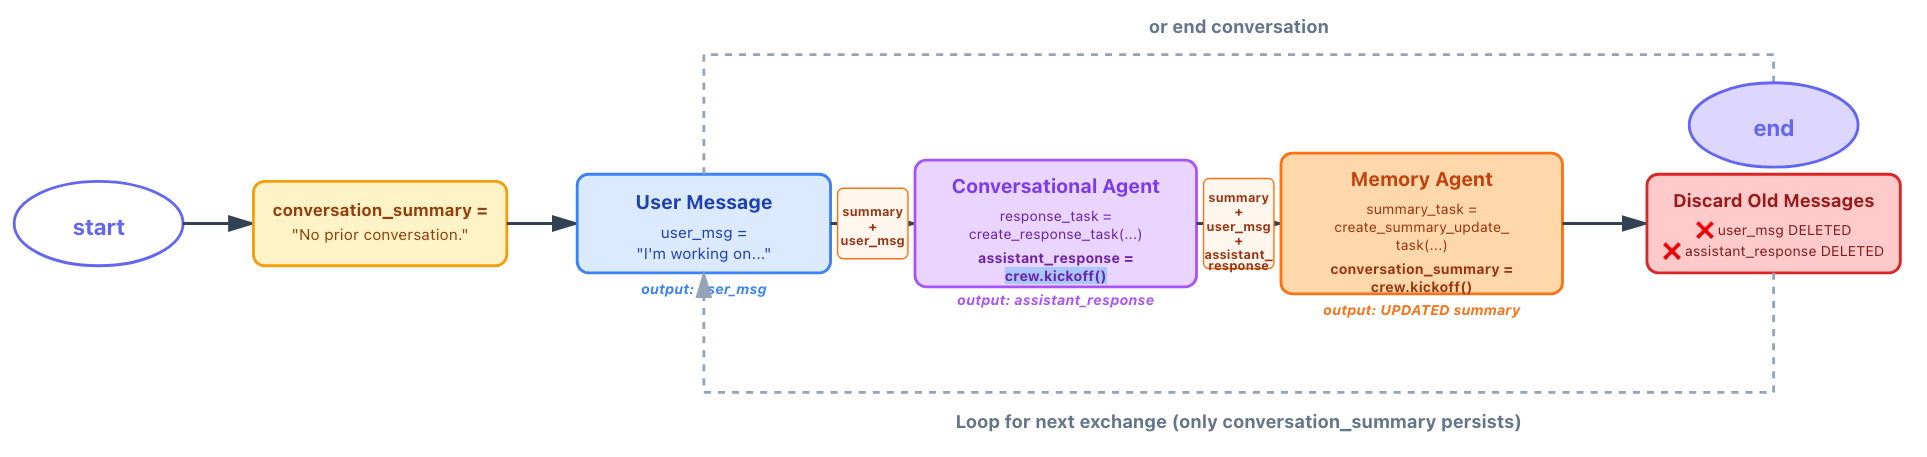

**What Happens in the Loop:**

**Exchange 1:**
- Summary: "No prior conversation"
- Conversation Agent responds to introduction
- Memory Agent creates NEW summary: "• User: David, teaches data science at Notre Dame"
- **Old messages discarded!**

**Exchange 2:**
- Summary: Previous summary about David
- Conversation Agent responds about biblical Hebrew + XGBoost
- Memory Agent REWRITES summary: "• User: David, Notre Dame • Research: Biblical Hebrew text analysis, XGBoost"
- **Previous exchange deleted! Only summary remains.**

**Exchange 3:**
- Summary: Updated version from Exchange 2
- Conversation Agent responds about teaching
- Memory Agent REWRITES again: "• David, Notre Dame • Research: Biblical Hebrew + XGBoost • Teaching: Python, NLP"
- **All previous exchanges gone! Only evolving summary.**

**Exchanges 4-5:**
- Conversation Agent answers questions using ONLY summary
- Can recall name, workplace, and research from summary
- Summary continues to evolve but stays ~130-150 words

In [ ]:
# Initialize conversation tracking
conversation_summary = "No conversation history yet."  # Start with empty summary

# Test conversation
user_messages = [
    "Hi! My name is David and I teach data science at Notre Dame.",
    "I'm working on biblical Hebrew text analysis using XGBoost.",
    "I also teach Python and NLP courses to my students.",
    "What's my name and where do I work?",
    "What research am I doing?"
]

print("="*70)
print("ROLLING SUMMARY MEMORY SYSTEM")
print()

for i, user_msg in enumerate(user_messages, 1):
    print(f"{'='*70}")
    print(f"EXCHANGE {i}")
    print(f"{'='*70}")
    print(f"User: {user_msg}\n")

    # ============================================================================
    # STEP 1: CONVERSATIONAL AGENT RESPONDS
    # ============================================================================
    # Create a Task for the conversational agent
    # This task contains:
    # - The current conversation summary (NOT full history)
    # - The user's new message
    # The agent will respond using ONLY these two pieces of information

    response_task = create_response_task(user_msg, conversation_summary)


    # Create a Crew to execute the response task
    # Crew: A team of agents working together on tasks
    # Components:
    # - agents: List of agents that can work on tasks (just conversational_agent here)
    # - tasks: List of tasks to complete (just response_task here)
    # - process: How tasks are executed (Process.sequential means one at a time)
    # - verbose: Whether to show detailed execution logs (False for clean output)

    response_crew = Crew(
        agents=[conversational_agent],      # Who can work on the task
        tasks=[response_task],              # What needs to be done
        process=Process.sequential,         # Execute tasks in order (only 1 task here)
        verbose=True                       # Don't show detailed logs
    )

    # Execute the crew with kickoff()
    # kickoff() runs all tasks in the crew and returns results
    # The conversational agent:
    # 1. Reads the task description (summary + user message)
    # 2. Generates a response using the LLM
    # 3. Returns the result

    response_result = response_crew.kickoff()


    # Extract the assistant's response from the result
    # .raw contains the text output from the agent
    # hasattr() checks if the result has a 'raw' attribute (it should)
    assistant_response = response_result.raw if hasattr(response_result, 'raw') else str(response_result)

    #print(f"Assistant: {assistant_response}\n")


    # ============================================================================
    # STEP 2: MEMORY AGENT UPDATES SUMMARY
    # ============================================================================
    # Create a Task for the memory agent
    # This task contains:
    # - OLD summary (what we had before this exchange)
    # - NEW user message (what user just said)
    # - NEW assistant response (what assistant just replied)
    # The agent will compress all this into an UPDATED summary

    summary_task = create_summary_update_task(
        conversation_summary,   # OLD summary
        user_msg,              # NEW user message
        assistant_response     # NEW assistant response
    )

    # Create a NEW Crew for the summarization task
    # Why a new crew? Because we're doing a different task with a different agent
    # This crew uses the memory_agent instead of conversational_agent
    # Process.sequential: Even though there's only 1 task, we specify the execution order

    summary_crew = Crew(
        agents=[memory_agent],          # Who can work on the task (memory keeper)
        tasks=[summary_task],           # What needs to be done (update summary)
        process=Process.sequential,     # Execute tasks in order
        verbose=True                   # Don't show detailed logs
    )


    # Execute the crew with kickoff()
    # The memory agent:
    # 1. Reads OLD summary + NEW exchange from task description
    # 2. Generates UPDATED summary using the LLM
    # 3. Returns the compressed summary (keeping it under 200 words)

    summary_result = summary_crew.kickoff()


    # Extract the updated summary and OVERWRITE the old one
    # This is the KEY step: we replace conversation_summary with the new version
    # The old summary is gone forever - only this new compressed version remains

    conversation_summary = summary_result.raw if hasattr(summary_result, 'raw') else str(summary_result)

    print(f"📋 Updated Summary ({len(conversation_summary.split())} words):")
    print(f"{conversation_summary}\n")
    # Loop repeats with only conversation_summary carrying forward
    # user_msg and assistant_response are thrown away

print("="*70)
print("FINAL STATISTICS")
print("="*70)
print(f"Summary length: ~{len(conversation_summary.split())} words")

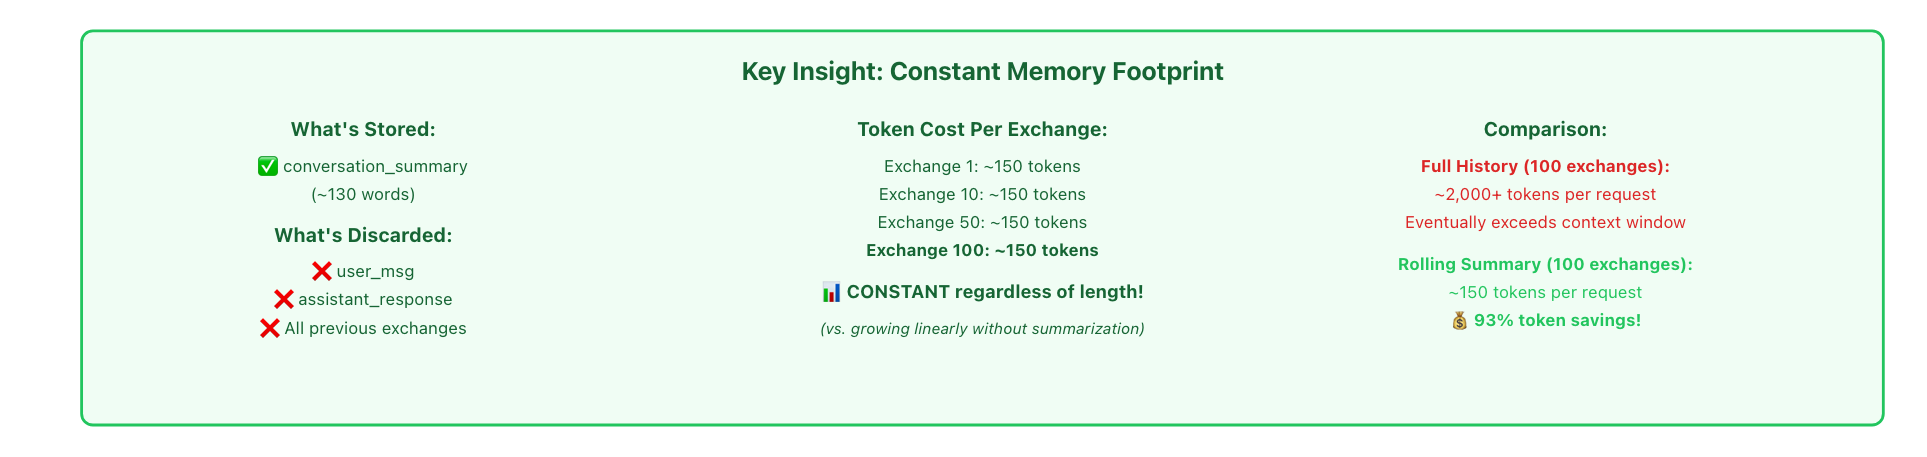

**Key Concepts Explained:**

**What is a Crew?**
A `Crew` is CrewAI's way of organizing agents and tasks. Think of it like a project team:
- **Agents**: Team members with specific skills (conversational agent, memory agent)
- **Tasks**: Jobs that need to be done (respond to user, update summary)
- **Process**: How tasks are executed (sequential = one at a time, hierarchical = with manager)
- **kickoff()**: Starts the work and returns results

**Process.sequential:**
- Tasks execute in the order they're listed in the `tasks=[]` parameter
- Each task completes before the next begins
- In our example, we only have 1 task per crew, so this doesn't matter much
- Alternative: `Process.hierarchical` (has a manager agent that delegates)

**Why Two Separate Crews?**
- We create a NEW crew for each task (response vs. summary)
- Each crew has different agents and different tasks
- Crews are temporary - they exist only to execute their tasks
- After `kickoff()`, the crew is done and we get the result